# Install Dependencies

In [ ]:
# restart kernel afterwards
# !pip install --upgrade setuptools


In [ ]:
# !pip install --upgrade ipykernel
# !pip install gym pyvirtualdisplay


In [ ]:
# !pip install ez_setup
!pip install gym[atari] cmake

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# link colab notebook to drive
# !ln -s /content/drive/My\ Drive/Colab\ Notebooks /content/colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and Helper functions


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gym

from tqdm.auto import tqdm


In [ ]:
from typing import List, Dict, Tuple, Optional, Union, Callable

State = int
Action = int
Reward = float

# Modules

In [ ]:
class Trainer:
    env: gym.Env

    def __init__(
        self,
        env: gym.Env,
        # *,
        # **kwargs,
        ):
        # save env
        self.env = env


        # store data of episodes in here
        self.episodes = []
        self.steps = []


    def get_action(self):
        raise NotImplementedError

    def update_on_step(
        self,
        *,
        cur_episode: int,
        cur_step: int,
        state: State,
        action: Action,
        next_state: State,
        reward: Reward,
        done: bool,
        info: Dict,
    ):
        raise NotImplementedError

    def update_on_done(
        self,
        cur_episode: int,
        ):
        raise NotImplementedError

    def run_episode(
        self,
        *,
        default_state: Optional[State] = None,
        max_steps: int = 200,
        ):
        # copy env
        env = self.env

        # record episode
        cur_episode = len(self.episodes)
        self.episodes += [{"episode": cur_episode, "step_data": []}]

        # init state
        state = env.reset()
        if default_state is not None:
            env.s = default_state
            state = default_state
        done = False

        for cur_step in range(max_steps):
            # choose action
            action = self.get_action(state)

            next_state, reward, done, info = env.step(action)

            ## update on step
            self.update_on_step(
                cur_episode=cur_episode,
                cur_step=cur_step,
                state=state,
                action=action,
                next_state=next_state,
                reward=reward,
                done=done,
                info=info,
            )
            state = next_state

            if done:
                break

        self.update_on_done(
            cur_episode=cur_episode,
        )


    def train(
        self,
        *,
        num_iters: int,
        **kwargs,
        ):

        for i in range(num_iters):
            self.run_episode(
                **kwargs,
            )


class QLearningTrainer(Trainer):
    def __init__(
        self,
        env,
        *,
        alpha: float,
        gamma: float,
        epsilon: float,
        **kwargs,
        ):

        super().__init__(
            env=env,
            **kwargs,
        )
        env = self.env

        ## store hyperparameters
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # init q-values
        self.q_table = np.zeros([env.observation_space.n, env.action_space.n])

    def get_action(self, state: State) -> Action:
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def update_on_step(
        self,
        *,
        cur_episode: int,
        cur_step: int,
        state: State,
        action: Action,
        next_state: State,
        reward: Reward,
        done: bool,
        info: Dict,
    ):
        # update q-values
        old_q = self.q_table[state, action]
        next_q = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] = old_q + self.alpha * (next_q - old_q)

        steps = self.episodes[cur_episode]["step_data"]
        steps += [
            {
                "cur_step": cur_step,
                "state": state,
                "next_state": next_state,
                "reward": reward,
                "done": done,
                "info": info,
            }
        ]



    def update_on_done(
        self,
        cur_episode: int,
    ):
        episode = self.episodes[cur_episode]

        episode["num_steps"] = len(episode["step_data"])

        ## todo: record data from last step
        # such as total reward, average reward, discounted reward
        last_step = episode["step_data"][-1]


        if cur_episode % 100 == 0:
            print(f"episode: {cur_episode}")
            print(f"num_steps: {episode['num_steps']}")
            print()


In [ ]:
# env = gym.make("Taxi-v3", new_step_api=True).env
env = gym.make("Taxi-v3", new_step_api=False).env
trainer = QLearningTrainer(
    env=env,
    alpha=0.1,
    gamma=0.99,
    epsilon=0.1,
)

trainer.train(
    num_iters=10000,
    default_state=None,
    max_steps=100000,
)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


episode: 0
num_steps: 521

episode: 100
num_steps: 170

episode: 200
num_steps: 130

episode: 300
num_steps: 113

episode: 400
num_steps: 8

episode: 500
num_steps: 76

episode: 600
num_steps: 43

episode: 700
num_steps: 19

episode: 800
num_steps: 14

episode: 900
num_steps: 80

episode: 1000
num_steps: 18

episode: 1100
num_steps: 22

episode: 1200
num_steps: 18

episode: 1300
num_steps: 17

episode: 1400
num_steps: 11

episode: 1500
num_steps: 24

episode: 1600
num_steps: 13

episode: 1700
num_steps: 12

episode: 1800
num_steps: 16

episode: 1900
num_steps: 15

episode: 2000
num_steps: 18

episode: 2100
num_steps: 16

episode: 2200
num_steps: 11

episode: 2300
num_steps: 13

episode: 2400
num_steps: 12

episode: 2500
num_steps: 12

episode: 2600
num_steps: 13

episode: 2700
num_steps: 15

episode: 2800
num_steps: 18

episode: 2900
num_steps: 17

episode: 3000
num_steps: 10

episode: 3100
num_steps: 17

episode: 3200
num_steps: 15

episode: 3300
num_steps: 15

episode: 3400
num_steps

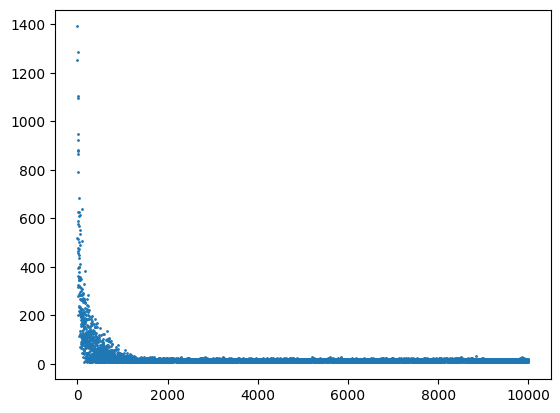

In [ ]:
# plot number of steps
df_res = pd.DataFrame(trainer.episodes).drop(columns=["step_data"])
plt.scatter("episode", "num_steps", data=df_res, s=1)
